# 서울시 범죄율
## 주민들이 거주하는 구는 안전할까?

1. 라이브러리 호출
2. 데이터 불러오기
3. 구글맵 API 호출
4. 데이터 전처리
    4-1. 경찰서 주소, 위도, 경도 추출
    4-2. 범죄 데이터 구별로 정리
5. 시각화
    5-1. Seaborn
    5-2. Folium

- crime_anal_police 데이터셋
- station_address = [] # 경찰서 주소
- station_lat = [] # 위도 latitude
- station_lng = [] #  경도 longitude

folium: 지도 시각화 

## 1. 라이브러리

In [2]:
import numpy as np   # 1.16.5
import pandas as pd  # 0.25.1
import googlemaps    # 4.6.0  (위도,경도) 경찰서의 위도 경도 받기 위해
from sklearn import preprocessing # '0.21.3' 데이터 '정규화 스케일'조정
import seaborn as sns # 0.9.0 그래프
import folium # 지도데이터
import json 

%matplotlib inline
import matplotlib.pyplot as plt # 3.1.1
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
f_path = 'C:\Windows\Fonts\malgun.ttf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font',family=font_name)

## 2. 데이터 불러오기

In [15]:
crime_anal_police = pd.read_csv('C:\\Users\\user\\Downloads\\DataScience-master\\DataScience-master\\data\\02. crime_in_Seoul.csv', thousands=',', encoding='euc-kr')
# crime_anal_police = pd.read_csv('~~\\02. crime_in_Seoul.csv', thousands=',', encoding='euc-kr')


In [16]:
crime_anal_police.shape # (31,11)

(31, 11)

In [17]:
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


## 3. 구글맵 API 불러오기

In [19]:
gmaps_key="~~" # google map API key
gmaps = googlemaps.Client(key=gmaps_key)

In [20]:
gmaps.geocode('서울중부경찰서', language='ko')

[{'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 수표로 27',
  'geometry': {'location': {'lat': 37.56361709999999, 'lng': 126.9896517},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.5649660802915,
     'lng': 126.9910006802915},
    'southwest': {'lat': 37.5622681197085, 'lng': 126.9883027197085}}},
  'partial_match': True,
  'place_id': 'ChIJc-9q5uSifDURLhQmr5wkXmc',
 

## 4. 데이터 전처리

### 4-1. 경찰서 주소, 위도, 경도 추출

In [21]:
tmp = gmaps.geocode('서울중부경찰서', language='ko')
print(tmp[0].get('formatted_address')) # 대한민국 서울특별시 중구 수표로 27
tmp[0].keys()

대한민국 서울특별시 중구 수표로 27


dict_keys(['address_components', 'formatted_address', 'geometry', 'partial_match', 'place_id', 'plus_code', 'types'])

In [22]:
station_name = []
for name in crime_anal_police['관서명']:
    station_name.append(''.join(['서울', name[:-1], '경찰서']))
station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

In [23]:
station_address = []
station_lat = [] # 위도 latitude
station_lng = [] #  경도 longitude
i = 0
for name in station_name:
    tmp = gmaps.geocode(name, language='ko')
    station_address.append(tmp[0].get('formatted_address'))
    
    tmp_loc = tmp[0].get("geometry")
    station_lat.append(tmp_loc['location']['lat'])
    station_lng.append(tmp_loc['location']['lng'])
    
    print(f"{name} -> {station_address[i]}")
    i += 1

서울중부경찰서 -> 대한민국 서울특별시 중구 수표로 27
서울종로경찰서 -> 대한민국 서울특별시 종로구 율곡로 46
서울남대문경찰서 -> 대한민국 서울특별시 중구 한강대로 410
서울서대문경찰서 -> 대한민국 서울특별시 서대문구 통일로 113
서울혜화경찰서 -> 대한민국 서울특별시 종로구 창경궁로 112-16
서울용산경찰서 -> 대한민국 서울특별시 용산구 백범로 329
서울성북경찰서 -> 대한민국 서울특별시 성북구 삼선동 보문로 170
서울동대문경찰서 -> 대한민국 서울특별시 동대문구 약령시로21길 29
서울마포경찰서 -> 대한민국 서울특별시 마포구 마포대로 183
서울영등포경찰서 -> 대한민국 서울특별시 영등포구 국회대로 608
서울성동경찰서 -> 대한민국 서울특별시 성동구 행당동 왕십리광장로 9
서울동작경찰서 -> 대한민국 서울특별시 동작구 노량진로 148
서울광진경찰서 -> 대한민국 서울특별시 광진구 구의동 자양로 167
서울서부경찰서 -> 대한민국 서울특별시 은평구 녹번동 177-15
서울강북경찰서 -> 대한민국 서울특별시 강북구 오패산로 406
서울금천경찰서 -> 대한민국 서울특별시 금천구 시흥대로73길 50
서울중랑경찰서 -> 대한민국 서울특별시 중랑구 묵2동 249-2
서울강남경찰서 -> 대한민국 서울특별시 강남구 테헤란로114길 11
서울관악경찰서 -> 대한민국 서울특별시 관악구 관악로5길 33
서울강서경찰서 -> 대한민국 서울특별시 강서구 화곡6동 980-27
서울강동경찰서 -> 대한민국 서울특별시 강동구 성내로 57
서울종암경찰서 -> 대한민국 서울특별시 성북구 화랑로7길 32
서울구로경찰서 -> 대한민국 서울특별시 구로구 가마산로 235
서울서초경찰서 -> 대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서 -> 대한민국 서울특별시 양천구 목동동로 99
서울송파경찰서 -> 대한민국 서울특별시 송파구 중대로 221
서울노원경찰서 -> 대한민국 서울특별시 노원구 노원로 283
서울방배경찰서 -> 대한민국 서울특별시 서초구 동작대로

In [24]:
gu_name = []

for name in station_address:
    tmp = name.split()
    
    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]
    
    gu_name.append(tmp_gu)
    
crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [25]:
crime_anal_police[crime_anal_police['관서명']=='금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,금천구


#### 임시저장

In [26]:
crime_anal_police.to_csv('Crime in Seoul.csv'
                        , sep=','
                        , encoding='cp949')

### 4-2.범죄 데이터 구별로 정리

In [39]:
crime_anal_raw = pd.read_csv('C:\\Users\\user\\Downloads\\DataScience-master\\DataScience-master\data\\02. crime_in_Seoul_include_gu_name.csv',encoding="utf-8")
# crime_anal_raw = pd.read_csv('~~\\02. crime_in_Seoul_include_gu_name.csv',encoding="utf-8")
crime_anal_raw.shape # (31,13)
crime_anal_raw.head(3)

,Unnamed: 0,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구


In [40]:
crime_anal_raw = pd.read_csv('C:\\Users\\user\\Downloads\\DataScience-master\\DataScience-master\data\\02. crime_in_Seoul_include_gu_name.csv',encoding="utf-8",index_col=0)
# crime_anal_raw = pd.read_csv('~~\\02. crime_in_Seoul_include_gu_name.csv',encoding="utf-8",index_col=0) # 첫번째 열을 index로 지정
crime_anal_raw.head(3)

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구


    - pivot_table사용 -> 구별로 범죄율 볼꺼니까 

In [41]:
crime_anal_ori = pd.pivot_table(crime_anal_raw, index='구별', aggfunc=np.sum)
crime_anal = crime_anal_ori.copy() # id(crime_anal) not is id(crime_anal_ori) = True
crime_anal.head(3)

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649


In [42]:
crime_anal['강간검거율'] = crime_anal['강간 검거']/crime_anal['강간 발생']*100
crime_anal['강도검거율'] = crime_anal['강도 검거']/crime_anal['강도 발생']*100
crime_anal['살인검거율'] = crime_anal['살인 검거']/crime_anal['살인 발생']*100
crime_anal['절도검거율'] = crime_anal['절도 검거']/crime_anal['절도 발생']*100
crime_anal['폭력검거율'] = crime_anal['폭력 검거']/crime_anal['폭력 발생']*100

del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,185.714286,100.000000,42.200925,83.047619


In [43]:
con_list = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

for column in con_list:
    crime_anal.loc[crime_anal[column] > 100, column] = 100 # 100이넘는애들의 해당데이터값을 100으로
    
crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


In [44]:
crime_anal.rename(columns={
    '강간 발생' : '강간'
    ,'강도 발생' : '강도'
    ,'살인 발생' : '살인'
    ,'절도 발생' : '절도'
    ,'폭력 발생' : '폭력'}, inplace=True)
crime_anal.head(3)

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222


    - sklearn -> 데이터 '정규화 스케일링'조정

In [45]:
col = ['강간','강도','살인','절도','폭력']
# min-max scaler : 모든 특성이 0~1 사이에 위치하도록
x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

# fit_transform = fit + tansform 2과정을 한번에 수행
x_scaled = min_max_scaler.fit_transform(x.astype(float)) # 정규화
crime_anal_norm = pd.DataFrame(x_scaled, columns=col, index=crime_anal.index)

col2 = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_anal_norm[col2] = crime_anal[col2] # 정규화 외 feature 이어붙이기
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619


In [46]:
result_cctv = pd.read_csv('C:\\Users\\user\\Downloads\\DataScience-master\\DataScience-master\\data\\01. CCTV_result.csv', encoding='UTF-8', index_col='구별')
# result_cctv = pd.read_csv('~~\\data\\01. CCTV_result.csv', encoding='UTF-8', index_col='구별')
crime_anal_norm[['인구수', 'CCTV']] = result_cctv[['인구수', '소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707


In [47]:
# 범죄 = '강간','강도','살인','절도','폭력'의 합
col = ['강간','강도','살인','절도','폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438


In [48]:
# 검거 = '강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율' 의 합
col = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701,369.707384
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551,370.084431
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746,406.943540
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667,368.622261
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438,416.915211


## 5. 시각화

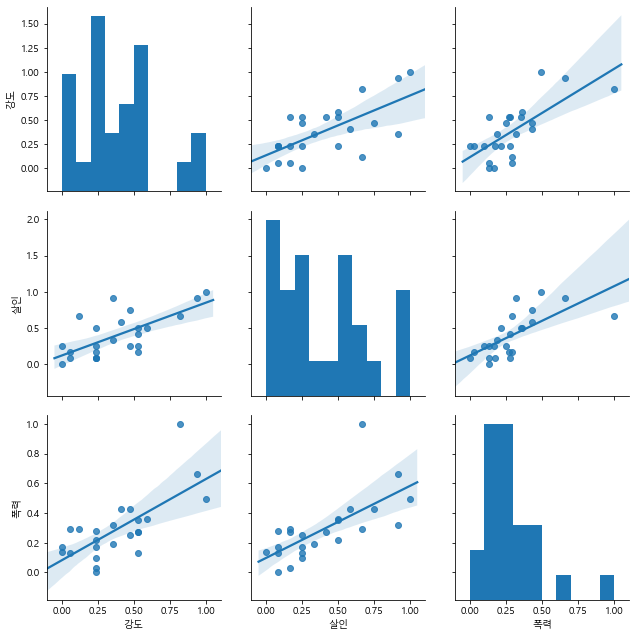

In [49]:
sns.pairplot(crime_anal_norm, vars=["강도","살인","폭력"], kind="reg", height=3)
plt.show()

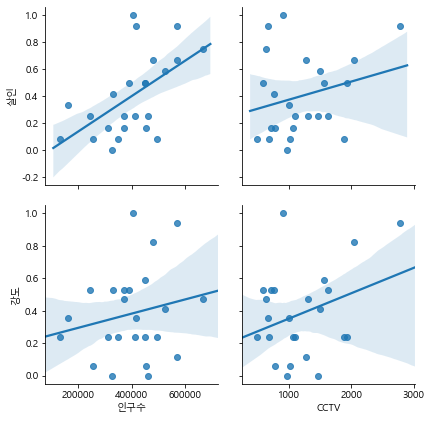

In [50]:
sns.pairplot(crime_anal_norm
             , x_vars=["인구수", "CCTV"]
             , y_vars=["살인","강도"]
             , kind='reg'
             , height=3)
plt.show()

 -> 계수로 보면 cctv가 증가함에따라 강도와 살인이 줄어든다고 해석하기에 모호하다.
하지만 시각화해보니 특정지점 이후로 강도랑 살인이 줄었네?

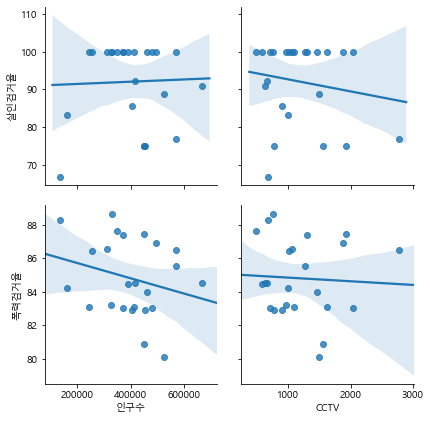

In [51]:
sns.pairplot(crime_anal_norm
            , x_vars=["인구수","CCTV"]
            , y_vars=["살인검거율","폭력검거율"]
            , kind='reg' # 회귀선추가
            , height=3)
plt.show()

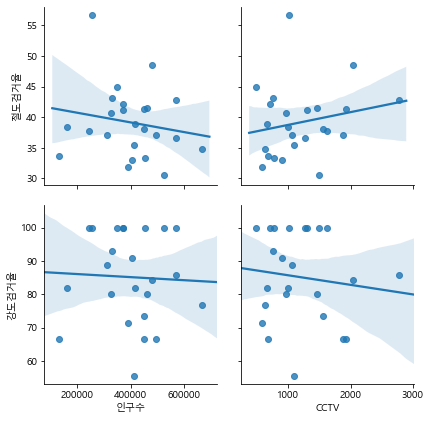

In [52]:
sns.pairplot(crime_anal_norm, x_vars=["인구수", "CCTV"], 
             y_vars=["절도검거율", "강도검거율"], kind='reg', height=3)
plt.show()

In [53]:
crime_anal_norm['검거'].sort_values()

구별
중구      320.649519
동작구     322.858850
구로구     325.647079
서초구     333.882725
영등포구    354.547963
종로구     363.991830
송파구     368.150048
관악구     368.622261
강남구     369.707384
강동구     370.084431
마포구     371.707327
은평구     375.674229
중랑구     376.644434
노원구     383.477292
서대문구    384.467802
성북구     388.153921
양천구     393.232162
강북구     406.943540
성동구     407.021764
용산구     409.997915
동대문구    412.885306
광진구     416.915211
금천구     423.928929
도봉구     432.593167
Name: 검거, dtype: float64

In [54]:
tmp_max = crime_anal_norm['검거'].max() # 검거제일 많은 구
crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max * 100 # 정규화
crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거', ascending=False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,348646.0,485,0.318627,100.000000
금천구,0.141210,0.058824,0.083333,0.172426,0.134074,80.794702,100.0,100.0,56.668794,86.465433,255082.0,1015,0.589867,97.997139
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.0,100.0,42.200925,83.047619,372164.0,707,2.034438,96.375820
동대문구,0.204611,0.470588,0.250000,0.314061,0.250887,84.393064,100.0,100.0,41.090358,87.401884,369496.0,1294,1.490147,95.444250
용산구,0.265130,0.529412,0.250000,0.169004,0.133128,89.175258,100.0,100.0,37.700706,83.121951,244203.0,1624,1.346674,94.776790


    - 히트맵으로 그리기
    두 개의 카테고리 값에 대한 값 변화를 한눈에 알기 쉽다. 대용량 데이터도 heatmap을 이용해 시각화 한다면 이미지 몇장으로 표현이 가능하다.

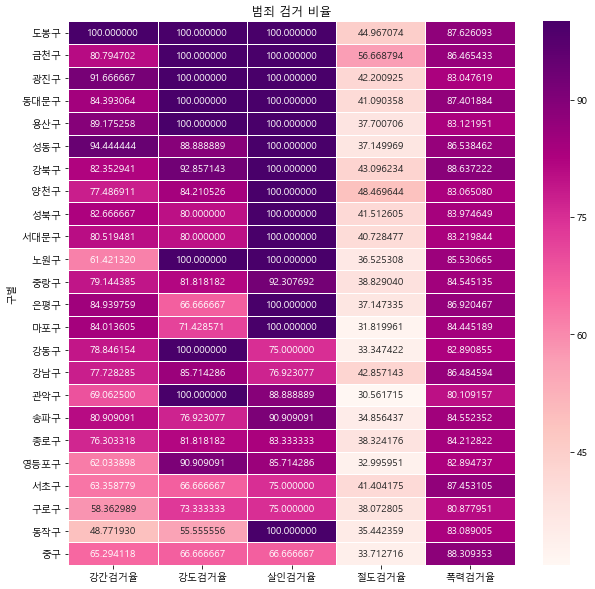

In [55]:
target_col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거',ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(crime_anal_norm_sort[target_col]
           , annot=True # cell에 값표시 
           , fmt='f' # annot가 true일때 값의 데이터타입을 float로
           , linewidths=.5 # cell사이에 선 집어넣는다
           , cmap='RdPu') # 히트맵 색. redpurple
plt.title("범죄 검거 비율")
plt.show()

->살인검거율은 전반적으로 다 높다.

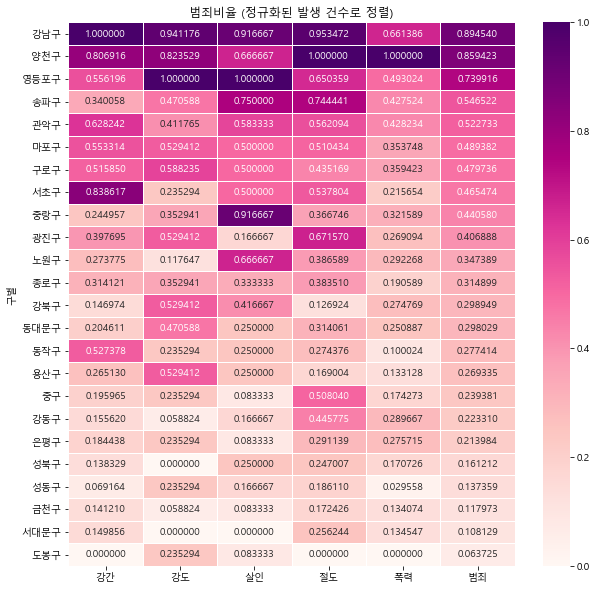

In [56]:
target_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_anal_norm['범죄'] = crime_anal_norm['범죄'] / 5
crime_anal_norm_sort = crime_anal_norm.sort_values(by='범죄', ascending=False)

plt.figure(figsize = (10,10))
sns.heatmap(crime_anal_norm_sort[target_col], annot=True, fmt='f', linewidths=.5,
                       cmap='RdPu')
plt.title('범죄비율 (정규화된 발생 건수로 정렬)')
plt.show()

-> 강남구는 전체적으로 다 높네. 영등포는 강도,살인이 높고
도봉구는 잘없네

In [57]:
# crime_anal_norm.to_csv('crime_in_Seoul.csv', sep=',', encoding='utf-8')

# 6. Folium

In [58]:
geo_path = 'C:\\Users\\user\\Downloads\\DataScience-master\\DataScience-master\\data\\02. skorea_municipalities_geo_simple.json'
# geo_path = '~~\\02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))
geo_str.keys() # ['type', 'features']
geo_str

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '강동구',
   'properties': {'code': '11250',
    'name': '강동구',
    'name_eng': 'Gangdong-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.11519584981606, 37.557533180704915],
      [127.16683184366129, 37.57672487388627],
      [127.18408792330152, 37.55814280369575],
      [127.16530984307447, 37.54221851258693],
      [127.14672806823502, 37.51415680680291],
      [127.12123165719615, 37.52528270089],
      [127.1116764203608, 37.540669955324965],
      [127.11519584981606, 37.557533180704915]]]}},
  {'type': 'Feature',
   'id': '송파구',
   'properties': {'code': '11240',
    'name': '송파구',
    'name_eng': 'Songpa-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.0690698130372, 37.522279423505026],
      [127.10087519791962, 37.524841220167055],
      [127.1116764203608, 37.540669955324965],
      [127.12123165719615, 37.52528270089

In [59]:
map = folium.Map(location=[37.5502, 126.982]
                ,zoom_start=10
                ,tiles='Stamen Toner')
map.choropleth(geo_data=geo_str
              ,data=crime_anal_norm['살인']
              ,columns=[crime_anal_norm.index,crime_anal_norm['살인']]
              ,foll_color='PuRd'
              ,key_on='feature.id')
map

C:\Users\user\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [60]:
map = folium.Map(location=[37.5502, 126.982]
                 ,zoom_start=10
                 ,tiles='Stamen Toner')

map.choropleth(geo_data = geo_str
               ,data = crime_anal_norm['강간']
               ,columns = [crime_anal_norm.index, crime_anal_norm['강간']]
               ,fill_color = 'YlGnBu' #PuRd, YlGnBu
               ,key_on = 'feature.id')
map

In [61]:
map = folium.Map(location=[37.5502, 126.982]
                 , zoom_start=10
                 , tiles='Stamen Toner')

map.choropleth(geo_data = geo_str
               ,data = crime_anal_norm['범죄']
               ,columns = [crime_anal_norm.index, crime_anal_norm['범죄']]
               ,fill_color = 'PuRd' #PuRd, YlGnBu
               ,key_on = 'feature.id')
map

In [62]:
tmp_criminal = crime_anal_norm['살인'] /  crime_anal_norm['인구수'] * 1000000

map = folium.Map(location=[37.5502, 126.982]
                 ,zoom_start=10
                 ,tiles='Stamen Toner')

map.choropleth(geo_data = geo_str
               ,data = tmp_criminal
               ,columns = [crime_anal.index, tmp_criminal]
               ,fill_color = 'PuRd' #PuRd, YlGnBu
               ,key_on = 'feature.id')
map

In [63]:
map = folium.Map(location=[37.5502, 126.982]
                 ,zoom_start=10
                 ,tiles='Stamen Toner')

map.choropleth(geo_data = geo_str
               ,data = crime_anal_norm['검거']
               ,columns = [crime_anal_norm.index, crime_anal_norm['검거']]
               ,fill_color = 'YlGnBu' #PuRd, YlGnBu
               ,key_on = 'feature.id')

map

#### 경찰서별 검거현황과 구별 범죄발생 현황을 표현하기

In [64]:
# 위도, 경도 데이터 추가
crime_anal_raw['lat'] = station_lat
crime_anal_raw['lng'] = station_lng

col = ['살인 검거', '강도 검거', '강간 검거', '절도 검거', '폭력 검거']
tmp = crime_anal_raw[col] / crime_anal_raw[col].max() # 정규화

crime_anal_raw['검거'] = np.sum(tmp, axis=1)
crime_anal_raw.head()


,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563617,126.989652,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575548,126.984747,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571968,126.998957,1.198382


In [65]:
map = folium.Map(location=[37.5502, 126.892]
                ,zoom_start=10)
for n in crime_anal_raw.index:
    folium.Marker([crime_anal_raw['lat'][n]
                  , crime_anal_raw['lng'][n]]).add_to(map)

map

In [66]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]], 
                        radius = crime_anal_raw['검거'][n]*10, 
                        color='#3186cc', fill_color='#3186cc', fill=True).add_to(map)
    
map

In [69]:
from folium.plugins import MarkerCluster
mc = MarkerCluster()
map = folium.Map(location=[37.5502, 126.982]
                ,zoom_start=10.2
                ,titles='Stamen Toner')
map.choropleth(geo_data=geo_str, data=crime_anal_norm['범죄']
               ,columns=[crime_anal_norm.index, crime_anal_norm['범죄']]
               ,fill_color='BrBG'
               ,key_on='feature.id')

# 클러스터에 더한다.
for n in crime_anal_raw.index:
    mc.add_child(folium.Marker(location=[crime_anal_raw['lat'][n], \
                                        crime_anal_raw['lng'][n]]
                              ,popup=crime_anal_raw['관서명'][n]))
map.add_child(mc)


for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]]
                       ,radius=crime_anal_raw['검거'][n]*10
                       ,color='#3186cc'
                       ,fill_color='#3186cc'
                       ,fill=True).add_to(map)
map

C:\Users\user\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [47]:
m = folium.Map(
    location=[37.55, 126.98],
    zoom_start=8
)

folium.Marker(
    location=[37.55, 126.98],
    icon = folium.Icon(color='red', icon='star') # Icon Marker 지정
).add_to(m)
m

In [119]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)

i = 0
tooltip="Click me"
for name in station_name:
    folium.Marker(location=[station_lat[i],station_lng[i]]
                 , icon=folium.Icon(color='green', icon='bell', prefix='fa')
                 , tooltip=tooltip # 커서 올리면 보임
                 , popup=name # 누르면 나옴
                 ).add_to(map)
    i +=1
map

In [131]:
'''
pyperclip : id, pw를 클립보드에 저장하려고
webdriver : 크롬실행시켜서 진행하려고 크롬드라이버불러오는 함수
bs4       :
'''
import pyperclip #1.8.2 # pip install pyperclip
import bs4 # 4.8.0 # pip install bs4
import time

from selenium import webdriver # 3.141.0 # pip install selenium 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC #selenium에서 사용할 모듈 import

driver = webdriver.Chrome("./chromedriver") #selenium 사용에 필요한 chromedriver.exe 파일 경로 지정
driver.get("https://map.naver.com/v5/") #네이버 신 지도 
try:
    element = WebDriverWait(driver, 10).until(
       EC.presence_of_element_located((By.CLASS_NAME, "input_search"))
   ) #입력창이 뜰 때까지 대기
finally:
    pass

search_box = driver.find_element_by_class_name("input_search")
search_box.send_keys("서울동작경찰서")
search_box.send_keys(Keys.ENTER) #검색창에 "서울 칵테일바" 입력


In [132]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['범죄'],
               columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')

for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]], 
                        radius = crime_anal_raw['검거'][n]*10, 
                        color='#3186cc', fill_color='#3186cc', fill=True).add_to(map)

    
# 경찰서위치
i = 0
tooltip="Click me"
for name in station_name:
    url = "https://map.naver.com/v5/search/"+name
    folium.Marker(location=[station_lat[i],station_lng[i]]
                 , icon=folium.Icon(color='green', icon='bell', prefix='fa')
                 , tooltip=tooltip # 커서 올리면 보임
                 , popup=f'<pre>{name}<br/>{station_address[i]}</pre>' # 누르면 나옴
                 ).add_to(map)
    i +=1
    
map

In [44]:
#map.save('seoul_map.html')

In [70]:
# def callFucntion(name):
#     driver = webdriver.Chrome("./chromedriver") #selenium 사용에 필요한 chromedriver.exe 파일 경로 지정
#     driver.get("https://map.naver.com/v5/") #네이버 신 지도 
#     try:
#         element = WebDriverWait(driver, 10).until(
#            EC.presence_of_element_located((By.CLASS_NAME, "input_search"))
#        ) #입력창이 뜰 때까지 대기
#     finally:
#         pass

#     search_box = driver.find_element_by_class_name("input_search")
#     search_box.send_keys(name)
#     search_box.send_keys(Keys.ENTER) #검색창에 "서울 칵테일바" 입력
    
# # map
# map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
# map.choropleth(geo_data = geo_str,
#                data = crime_anal_norm['범죄'],
#                columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
#                fill_color = 'PuRd', #PuRd, YlGnBu
#                key_on = 'feature.id')

# for n in crime_anal_raw.index:
#     folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]], 
#                         radius = crime_anal_raw['검거'][n]*10, 
#                         color='#3186cc', fill_color='#3186cc', fill=True).add_to(map)

    
# # 경찰서위치
# import requests
# import json

# i = 0
# tooltip="Click me"
# for name in station_name:
#     url = f'https://map.naver.com/v5/search/{name}'

#     folium.Marker(location=[station_lat[i],station_lng[i]]
#                  , icon=folium.Icon(color='green', icon='bell', prefix='fa')
#                  , tooltip=tooltip # 커서 올리면 보임
# #                  , popup=folium.Popup(max_width=450).add_child(folium.Vega(callFucntion(name), width=450, height=250))
#                  , popup=f'<pre><a href="url">{name}</a><br/>{station_address[i]}</pre>' # 누르면 나옴
#                  ).add_to(map)
#     i +=1
    
# map